## RNN Model Performing Seq2Seq Labeling (POS Taging) on NLTK Corpus

#### Run the entire notebook cell by cell to generate the results as explained in the 'Process - Dropped Seq2Seq Labeling Task' Section of the Report. 

#### May need to download some required package libraries for successful implementation.

#### Download the Word2Vec Embeddings from this repo 'https://github.com/mmihaltz/word2vec-GoogleNews-vectors/blob/master/GoogleNews-vectors-negative300.bin.gz' and unzip bin file. Then update path in word-embedding cell.

#### Dataset and Packages

In [1]:
# importing basic pandas and numpy libraries
import pandas as pd
import numpy as np

In [2]:
# importing dataset libraries
from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import nltk
# nltk.download('treebank')
# nltk.download('brown')
# nltk.download('conll2000')
# nltk.download('universal_tagset')

# load POS tagged corpora from NLTK
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

#### Dataset Pre-Processing

In [3]:
# splitting words and tags into separate sentences as lists of equal lengths
sentence_list_words = []
sentence_list_postags = []
for sentence in tagged_sentences:
    sentence_list_words.append([sentence[i][0] for i in range(len(sentence))])
    sentence_list_postags.append([sentence[i][1] for i in range(len(sentence))])

In [4]:
# tokenizing both words and postags
from keras_preprocessing.text import Tokenizer

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(sentence_list_words)
sentence_list_words_encoded = word_tokenizer.texts_to_sequences(sentence_list_words)  

postag_tokenizer = Tokenizer()
postag_tokenizer.fit_on_texts(sentence_list_postags)
sentence_list_postags_encoded = postag_tokenizer.texts_to_sequences(sentence_list_postags)

In [5]:
# padding the sentences to ensure equal length since we are working with an RNN
from keras_preprocessing.sequence import pad_sequences

MAX_SEQ_LENGTH = 100
sentence_list_words = pad_sequences(sentence_list_words_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
sentence_list_postags = pad_sequences(sentence_list_postags_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

#### Word Embeddings

In [6]:
# importing gensim library of Google-News-300 word embeddings
from gensim.models import KeyedVectors
from keras.layers import Embedding, Dense, TimeDistributed, LSTM, GRU, Bidirectional, SimpleRNN, RNN

path = r'C:\Users\Abhinav Gupta\OneDrive\Desktop\ML\ML Project\GoogleNews-vectors-negative300.bin'
word2vec= KeyedVectors.load_word2vec_format(path, binary=True)

In [7]:
# using pre-trained word emeddings of Word2Vec model to create this tasks word embeddings
EMBEDDING_SIZE  = 300 
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
word2id = word_tokenizer.word_index

for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [8]:
# forming one-hot encoded vectors for the pos-tags (labels)
from keras.utils import to_categorical
sentence_list_postags = to_categorical(sentence_list_postags)

In [9]:
# splitting data into train, test, and val dataset for performing the seq2seq task
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(sentence_list_words, sentence_list_postags, test_size=TEST_SIZE, random_state=4)

VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

#### RNN

In [10]:
# 
from keras.models import Sequential
from keras import layers, regularizers

NUM_CLASSES = sentence_list_postags.shape[2]

rnn_model = Sequential()

rnn_model.add(Embedding(input_dim = VOCABULARY_SIZE, output_dim = EMBEDDING_SIZE, trainable = False))

rnn_model.add(SimpleRNN(64, return_sequences=True))

rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [11]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 75s 141ms/step - acc: 0.7822 - loss: 0.7638 - val_acc: 0.8948 - val_loss: 0.3523
Epoch 2/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - acc: 0.9018 - loss: 0.3246 - val_acc: 0.9236 - val_loss: 0.2491
Epoch 3/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 54s 133ms/step - acc: 0.9265 - loss: 0.2380 - val_acc: 0.9358 - val_loss: 0.2034
Epoch 4/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 59s 144ms/step - acc: 0.9375 - loss: 0.1981 - val_acc: 0.9433 - val_loss: 0.1766
Epoch 5/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 52s 127ms/step - acc: 0.9446 - loss: 0.1733 - val_acc: 0.9489 - val_loss: 0.1584
Epoch 6/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 49s 120ms/step - acc: 0.9499 - loss: 0.1558 - val_acc: 0.9526 - val_loss: 0.1465
Epoch 7/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 50s 123ms/step - acc: 0.9528 - loss: 0.1453 - val_acc: 0.9546 - val_loss: 0.1381
Epoch 8/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 50s 122ms/step - acc: 0.9547 - loss: 0.1384 - val_acc: 0.9560 - val_loss: 0.1325
Epoch 9/10
408/408 ━━━━━━━━━━━━━

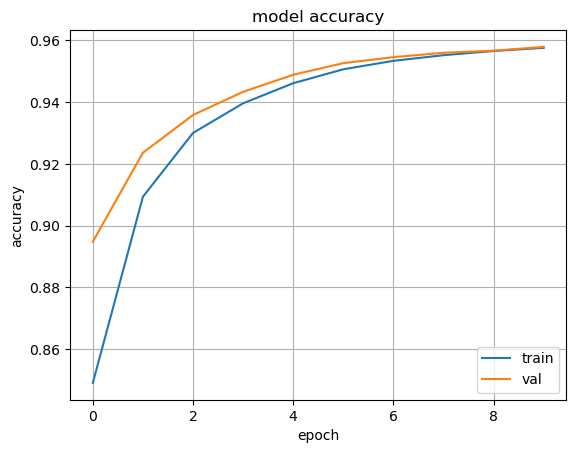

In [12]:
from matplotlib import pyplot as plt

plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'l2_train', 'l2_val'], loc="lower right")
plt.show()

In [13]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.9582 - loss: 0.1244
Loss: 0.124915212392807,
Accuracy: 0.9580833911895752
